# Quantum jump duration estimated with model convoluted with Detector response

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from uncertainties import unumpy
from uncertainties import ufloat

%matplotlib inline

## Signal import

In [2]:
data_file = 'data/raw_data/selected_g2/20170529_FWMg2_MPD_MPDGated_4GHzOsci_4MHzBlueDetuned.dat'

# import oscilloscope data into time and counts vectors. cut off the edges
Dt, counts = np.flipud(np.genfromtxt(data_file, skip_header=5, delimiter=',')).T
Dt_step = np.abs(np.mean(np.diff(Dt)))

# usable_range = range(len(Dt))
usable_range = range(543, 4994)
counts = counts[usable_range]
Dt = -Dt[usable_range]

counts_err = np.sqrt(counts)
counts_u = unumpy.uarray(counts, counts_err)
print('Time resolution: {:.3e}'.format(Dt_step))

Time resolution: 1.000e-11


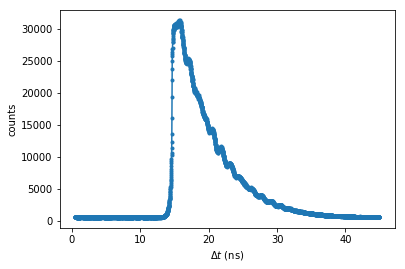

In [3]:
plt.figure('FWM data, time resolution: {:.3g} ns'.format(np.mean(np.diff(Dt))* 1e9))
plt.plot(Dt*1e9, counts, '.-')
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts');

## Detector transfer function

In [4]:
from lmfit import Model
from lmfit import Parameters
from lmfit.models import ConstantModel
from lmfit.models import ExponentialModel
from lmfit.models import GaussianModel
from lmfit.models import LorentzianModel

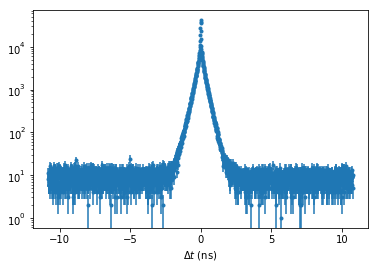

In [5]:
mpd_datafile = 'data/raw_data/MPD_characterization/F1pmp1actrigger.txt'
Dt_mpd, counts_mpd = np.genfromtxt(mpd_datafile, delimiter=',', skip_header=5).T
Dt_mpd_step = np.mean(np.diff(Dt_mpd))

# drop zero bins and center the MPD response function
peak_idx = np.argmax(counts_mpd)
mpd_center = counts_mpd[4:peak_idx + (peak_idx - 5)]
mpd_t = (np.arange(len(mpd_center)) - len(mpd_center)//2 - 1) * Dt_mpd_step

# poissonian error
mpd_error = np.sqrt(mpd_center)

# sets the floor range where accidental counts are the main component
flat_range = list(range(500)) + list(range(len(mpd_t)-500, len(mpd_t)))

plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, fmt='.')
plt.xlabel(r'$\Delta t$ (ns)');
plt.yscale('log')

### Baseline removal

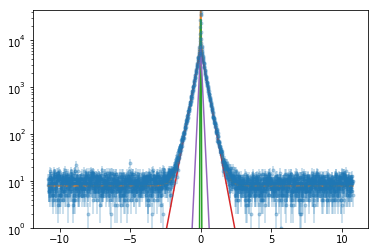

In [6]:
# Model of the detector response
response_model = (ConstantModel(prefix='offset_') +
                  ExponentialModel(prefix='a_') +
                  ExponentialModel(prefix='b_')  +
                  GaussianModel(prefix='c_')
                 )

# Initial parameters setting
p_peak = response_model.make_params()
p_peak['offset_c'].set(value=min(mpd_center))
p_peak['a_decay'].set(value=1)
p_peak['a_amplitude'].set(value=1e2)
p_peak['b_decay'].set(value=1)
p_peak['b_amplitude'].set(value=1e2)
p_peak['c_amplitude'].set(value=1e3)
p_peak['c_sigma'].set(value=.1)
p_peak['c_center'].set(value=0, vary=1)

mpd_result = response_model.fit(mpd_center,
                                x=np.abs(mpd_t * 1e9),
                                params=p_peak,
                                weights=1 / mpd_error
                               )
# print(mpd_result.fit_report())
comps = mpd_result.eval_components()
plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, alpha=.3, fmt='.')
plt.plot(mpd_t * 1e9, mpd_result.best_fit);
plt.plot(mpd_t * 1e9, comps['c_']);
plt.plot(mpd_t * 1e9, comps['a_']);
plt.plot(mpd_t * 1e9, comps['b_']);
plt.ylim(min(mpd_center))
plt.yscale('log')

In [7]:
# Defining the normalized response function, including errors
mpd_counts_u = (unumpy.uarray(mpd_center, mpd_error) -
                ufloat(mpd_result.params['offset_c'].value,
                       mpd_result.params['offset_c'].stderr))

# normalization
norm_u = np.sum(mpd_counts_u)
mpd_u = mpd_counts_u / norm_u
mpd_error = unumpy.std_devs(mpd_u)
mpd = unumpy.nominal_values(mpd_u)

## Fitting

In [8]:
from lmfit import fit_report
from lmfit import Minimizer
from scipy.signal import convolve

### Fit function and parameters initialization

In [98]:
def jump(x, alpha):
    """ Sigmoid to model the rising edge"""
    return 1 / (1 + np.exp(- x / alpha))


def rise_decay_f(x, alpha, t0, tau):
    """Heuristic model of the jump"""
    x = x - t0
    retval = jump(x, alpha) * np.exp(-x / tau)
    return retval / max(retval)


def rise_time(alpha):
    # return 90/10 rise time from the edge
    c = np.log(1.8/.2) / 2
    return alpha * c * 4


def residuals(params, x_array, data=None, eps=None):
    parvals = params.valuesdict()
    alpha = parvals['alpha']
    tau = parvals['tau']
    x0 = parvals['x0']
    Amp = parvals['Amp']
    c = parvals['c']

    model = Amp * rise_decay_f(x_array, alpha, x0, tau)
    model = convolve(model, mpd, mode='same') + c

    if data is None:
        return model

    if eps is None:
        return model - data

    return (model - data) / eps

<IPython.core.display.Javascript object>


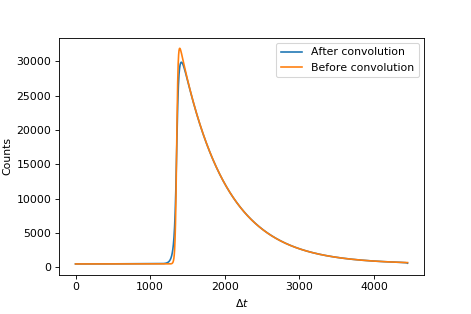

In [99]:
p = Parameters()
p.add('alpha', .1, min=0)
p.add('x0', 14)
p.add('tau', 6, min=0)
p.add('c', np.mean(counts[:200]), vary=1)
p.add('Amp', max(counts), min=0)
p.add('rise_time', 0, expr='log(1.8/.2) * 2 * alpha')

# test
%matplotlib notebook

parvals = p.valuesdict()
alpha = parvals['alpha']
tau = parvals['tau']
x0 = parvals['x0']
Amp = parvals['Amp']
c = parvals['c']

plt.figure(' Test of the fit model')
plt.plot(residuals(p, x_array=Dt*1e9), label='After convolution')
plt.plot(Amp * rise_decay_f(Dt*1e9, alpha, x0, tau) + c, label='Before convolution')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Counts')
plt.legend();

### Least Square fit 

In [100]:
mini = Minimizer(residuals, p, (Dt*1e9, counts, counts_err))
result = mini.minimize()
print(result.params.pretty_print())
print(fit_report(result))

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
Amp        3.772e+04        0      inf    107.3     True     None     None
alpha      0.004865        0      inf 0.002993     True     None     None
c             441.2     -inf      inf    2.168        1     None     None
rise_time   0.02138     -inf      inf  0.01315    False log(1.8/.2) * 2 * alpha     None
tau           5.278        0      inf 0.006424     True     None     None
x0            14.63     -inf      inf 0.001003     True     None     None
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 4451
    # variables        = 5
    chi-square         = 72477.8671
    reduced chi-square = 16.3018145
    Akaike info crit   = 12428.9685
    Bayesian info crit = 12460.9729
[[Variables]]
    alpha:      0.00486544 +/- 0.00299252 (61.51%) (init = 0.1)
    x0:         14.6333283 +/- 0.00100327 (0.01%) (init = 14)
    tau:        5.27813754 +/- 0.00642

<IPython.core.display.Javascript object>


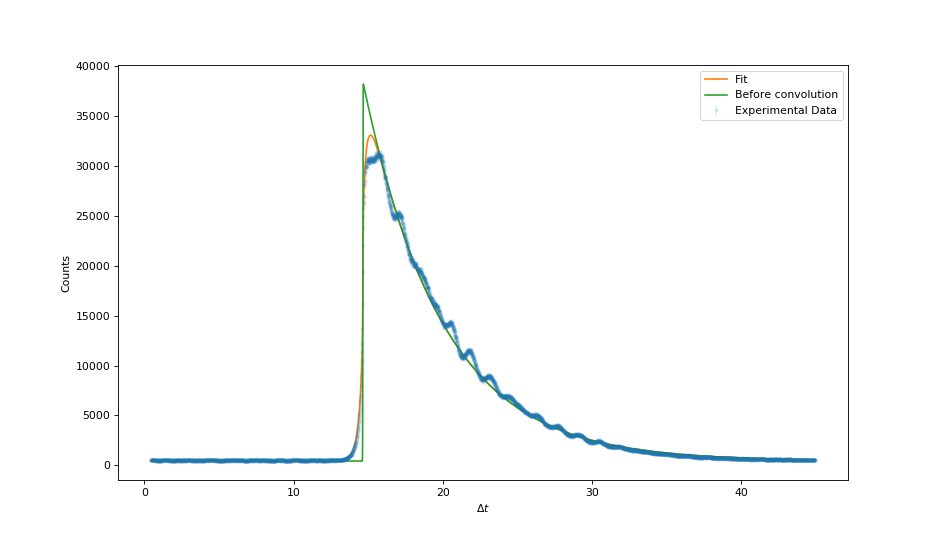

In [101]:
plt.figure('Result of the Least Square fit ', figsize=(12, 7))
plt.errorbar(Dt*1e9, counts, yerr=counts_err,
             fmt='.',
             alpha=.1,
             label='Experimental Data')
plt.plot(Dt*1e9, residuals(result.params, x_array=Dt*1e9), label='Fit')

parvals = result.params.valuesdict()
alpha = parvals['alpha']
tau = parvals['tau']
x0 = parvals['x0']
Amp = parvals['Amp']
c = parvals['c']
plt.plot(Dt*1e9, Amp * rise_decay_f(np.longfloat(Dt*1e9), alpha, x0, tau) + c,
         label='Before convolution')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Counts')
plt.legend();

In [13]:
print('90/10 rise time from least square fit: {:.2u} ns\n'.format(ufloat(result.params['rise_time'].value,
                                                                      result.params['rise_time'].stderr)))

90/10 rise time from least square fit: 0.021+/-0.013 ns



###  Bayesian parameter estimation using Markov Chain Monte Carlo

In [14]:
import corner
import multiprocessing

from lmfit import report_fit

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 1   # arbitrary default
print('Numbe rof CPU to use for multi-processing {}'.format(cpus))

Numbe rof CPU to use for multi-processing 4


In [102]:
result.params.add('noise', value=1, min=0.001, max=10)


def lnprob(p):
    """log-likelihood probability for the sampling"""
    noise = p['noise']
    return -0.5 * np.sum((residuals(p, np.longfloat(Dt*1e9), data=counts, eps=counts_err) / noise)**2 + np.log(2 * np.pi * noise**2))

In [103]:
mini2 = Minimizer(lnprob, result.params, nan_policy='omit')

with multiprocessing.Pool(cpus) as pool:
    res = mini2.emcee(burn=300, steps=1000, thin=20, params=result.params, is_weighted=True, workers=pool)

[[Variables]]
    alpha:      0.00462847 +/- 0.00244713 (52.87%) (init = 0.004865441)
    x0:         14.6332602 +/- 0.00121878 (0.01%) (init = 14.63333)
    tau:        5.27804140 +/- 0.00626536 (0.12%) (init = 5.278138)
    c:          441.164189 +/- 2.10343920 (0.48%) (init = 441.1532)
    Amp:        37722.7231 +/- 129.696015 (0.34%) (init = 37715.63)
    rise_time:  0.02033958 == 'log(1.8/.2) * 2 * alpha'
    noise:      4.03723576 +/- 0.04185391 (1.04%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, Amp) = -0.912
    C(alpha, x0)  =  0.423
    C(tau, c)     = -0.421
    C(x0, Amp)    = -0.336
    C(tau, Amp)   = -0.260
    C(x0, tau)    = -0.193


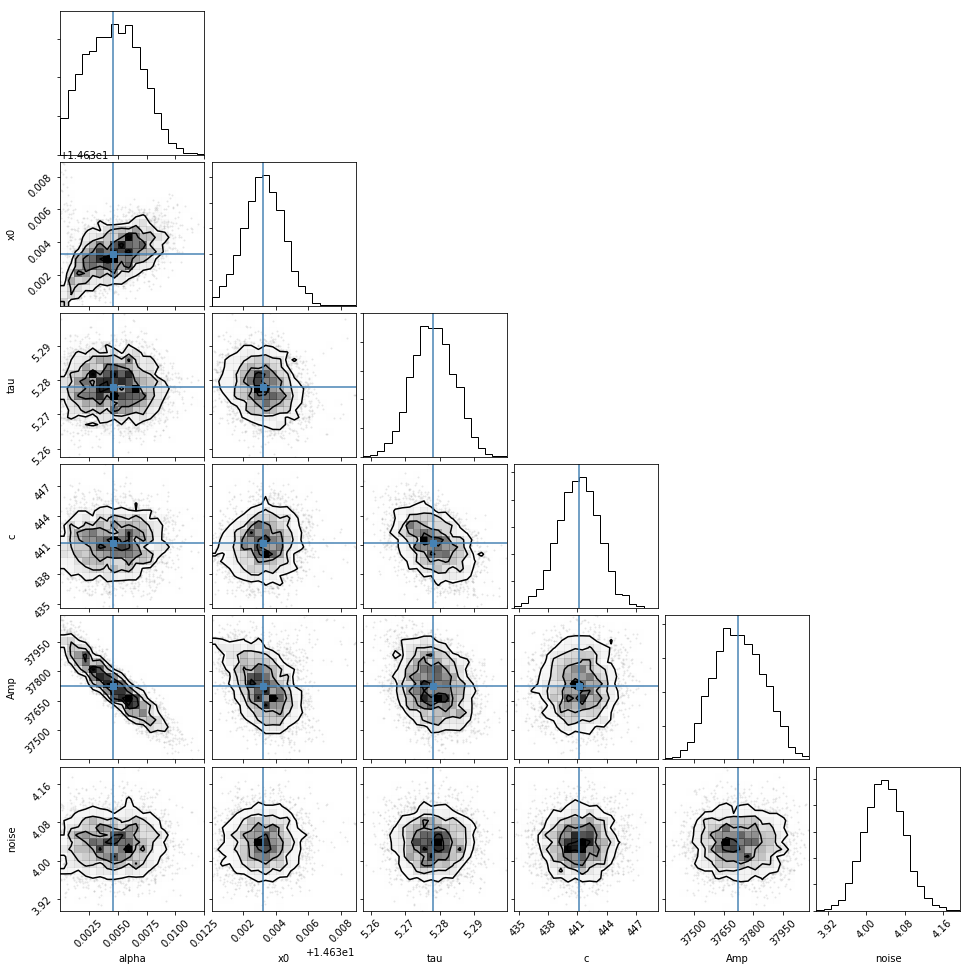

In [104]:
%matplotlib inline
corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()));
report_fit(res.params)

### Final estimation of jump time

In [105]:
quantiles_alpha = np.percentile(res.flatchain['alpha'], [2.28, 15.9, 50, 84.2, 97.7])
sigma_right = rise_time(quantiles_alpha[3]) - rise_time(quantiles_alpha[2])
sigma_left = rise_time(quantiles_alpha[2]) - rise_time(quantiles_alpha[1])

print('10/90 rise time from Bayesian estimation: {:.2u} ns\n'.format(ufloat(rise_time(res.params['alpha'].value),
                                                                      max(sigma_right, sigma_left))))

10/90 rise time from Bayesian estimation: 0.020+/-0.011 ns



### Confidence intervals for plotting

In [106]:
def eval_model(p_dic):
    """ evaluate the model from a dictionary of parameters"""
    p_temp = Parameters()
    [p_temp.add(j, p_dic[j]) for j in p_dic.keys()]
    return residuals(p_temp, Dt*1e9)

#     ci_bands = [eval_model(k) for k in res.flatchain.to_dict(orient='records')]

with multiprocessing.Pool(cpus) as pool:        
    worker = pool.map_async(eval_model, res.flatchain.to_dict(orient='records'))
    worker.wait()

# # # Get the median and standard deviation for each point of the fit
temp_traces = np.array(worker.get())
ci_bands = np.percentile(temp_traces, [.5, 2.28, 15.9, 50, 84.2, 97.7, 99.5], axis=0)

<IPython.core.display.Javascript object>


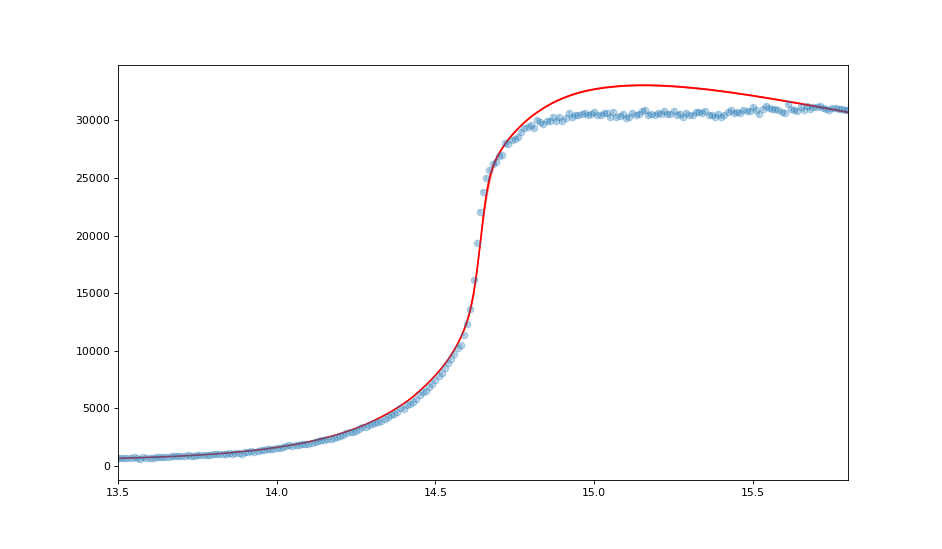

In [107]:
%matplotlib notebook

plt.figure(figsize=(12, 7))
plt.errorbar(Dt*1e9, counts, yerr=counts_err, fmt='o', alpha=.3)
plt.fill_between(Dt*1e9, ci_bands[0], ci_bands[6], facecolor='red', alpha=.2)
plt.fill_between(Dt*1e9, ci_bands[1], ci_bands[5], facecolor='red', alpha=.4)
plt.fill_between(Dt*1e9, ci_bands[2], ci_bands[4], facecolor='red', alpha=.5)
plt.plot(Dt*1e9, ci_bands[3], 'r')
plt.xlim(13.5, 15.8);

## Save data to file

In [ ]:
# with open('data/processed_data/quantum-jump.dat', 'w') as f:
#     f.write('#Dt\tcounts\tcounts_err\t'
#             'fit\tfit_ci_low\tfit_ci_hi\n')
#     [f.write(('{}\t'*5 + '{}\n').format(*k))
#      for k
#      in zip(Dt*1e9, counts, counts_err, quantiles[3], quantiles[0], quantiles[6])]